In [2]:
%matplotlib notebook

from modsim import *

In [3]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
radian = UNITS.radian
newton = UNITS.newton

In [4]:
condition = Condition(x = 0 * m, 
                      y = 1 * m,
                      g = 9.8 * m/s**2,
                      mass = 79.4 * kg,
                      diameter = 0.4472 * m,
                      rho = 1.2 * kg/m**3,
                      C_d = 0.25,
                      angle = 45 * degree,
                      velocity = 60 * m / s,
                      duration = 8.5 * s)

In [5]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

### PHASE 1

In [6]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
    
    f_drag = -rho * v.mag * v * C_d * area / 2
    a_drag = f_drag / mass
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [64]:
system = make_system(condition)
run_odeint(system, slope_func)

In [65]:
xs = system.results.x
ys = system.results.y

In [61]:
ys.head

<bound method NDFrame.head of 0.0      1.000000
0.1      5.189412
0.2      9.272582
0.3     13.249831
0.4     17.121470
0.5     20.887802
0.6     24.549125
0.7     28.105727
0.8     31.557889
0.9     34.905886
1.0     38.149985
1.1     41.290447
1.2     44.327526
1.3     47.261467
1.4     50.092513
1.5     52.820897
1.6     55.446848
1.7     57.970586
1.8     60.392329
1.9     62.712288
2.0     64.930665
2.1     67.047663
2.2     69.063474
2.3     70.978287
2.4     72.792288
2.5     74.505655
2.6     76.118564
2.7     77.631185
2.8     79.043686
2.9     80.356228
          ...    
7.1     47.098073
7.2     44.247166
7.3     41.302921
7.4     38.265543
7.5     35.135237
7.6     31.912214
7.7     28.596689
7.8     25.188882
7.9     21.689014
8.0     18.097314
8.1     14.414012
8.2     10.639344
8.3      6.773550
8.4      2.816873
8.5     -1.230439
8.6     -5.368133
8.7     -9.595955
8.8    -13.913644
8.9    -18.320936
9.0    -22.817562
9.1    -27.403252
9.2    -32.077728
9.3    -36.84071

<IPython.core.display.Javascript object>


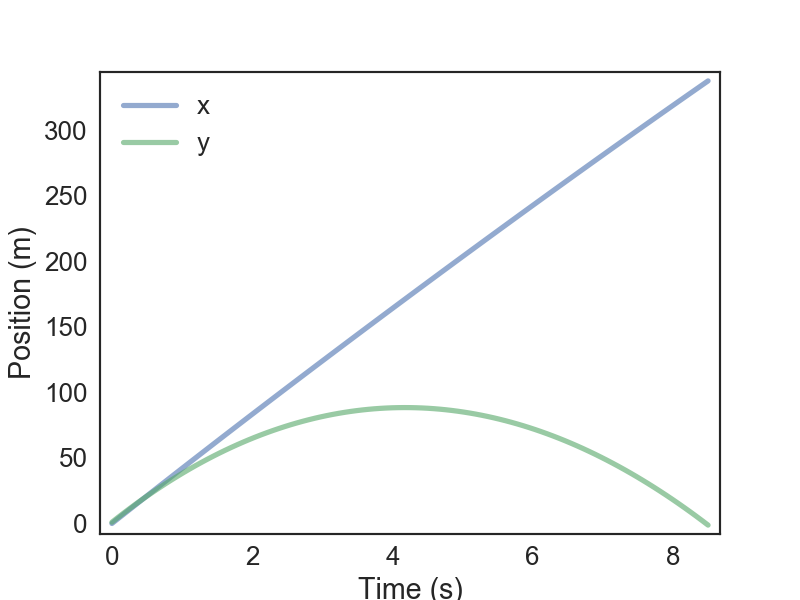

In [66]:
#plotting x and y as functions of time
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

<IPython.core.display.Javascript object>


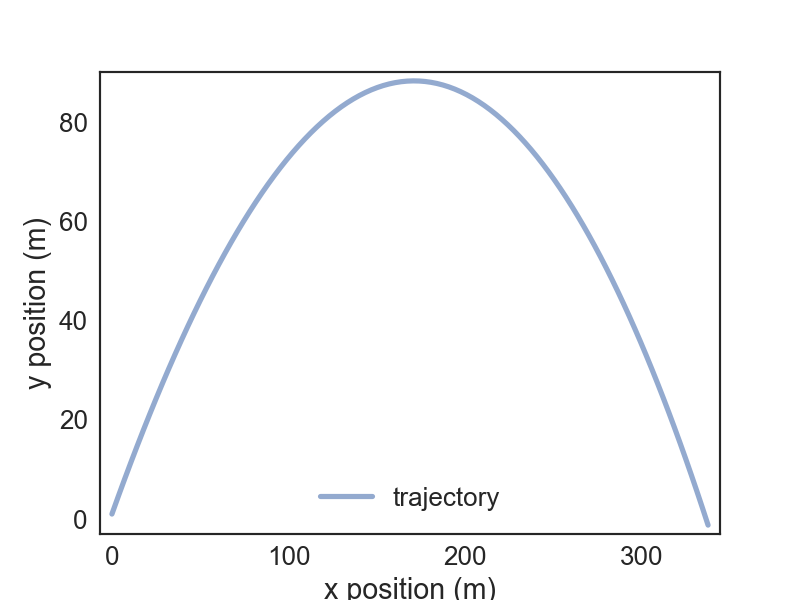

In [67]:
#trajectory plot
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

<IPython.core.display.Javascript object>


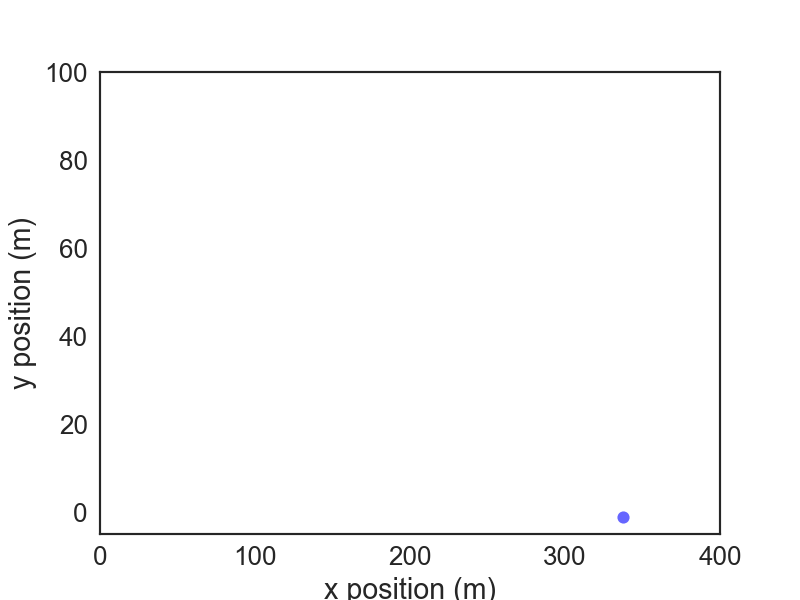

In [69]:
#animation
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[0, 400],
         ylim=[-5, 100],
         legend=False)

for x, y in zip(xs, ys):
    plot(x, y, 'bo', update=True)
    sleep(0.01)

In [7]:
def animate2d(xs, ys, speedup=1):
    """Animate the results of a projectile simulation.
    
    xs: x position as a function of time
    ys: y position as a function of time
    
    speedup: how much to divide `dt` by
    """
    # get the time intervals between elements
    ts = xs.index
    dts = np.diff(ts)
    dts = np.append(dts, 0)

    # decorate the plot
    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[xs.min(), xs.max()],
             ylim=[ys.min(), ys.max()],
             legend=False)

    # loop through the values
    for x, y, dt in zip(xs, ys, dts):
        plot(x, y, 'bo', update=True)
        sleep(dt / speedup)

In [8]:
def interpolate_range(results):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = results.x
    ys = results.y
    t_end = ys.index[-1]
    
    if ys[t_end] > 0:
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    t_land = T(0)
    X = interpolate(xs, kind='cubic')
    return X(t_land)

In [9]:
#takes launch angle, returns range
def range_func(angle, condition):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    condition: Condition object
    
    returns: distance in meters
    """
    condition.set(angle=angle)
    system = make_system(condition)
    run_odeint(system, slope_func)
    x_range = interpolate_range(system.results)
    return x_range

In [55]:
range_func(45, condition)

array(336.3824698970658)

### PHASE 2

In [107]:
condition2 = Condition(x = 0 * m, 
                      y = 1 * m,
                      g = 9.8 * m/s**2,
                      mass = 108.1 * kg, #10 kg fuel, 18.7 kg jetpack, 79.4 kg person
                      diameter = 0.4472 * m,
                      rho = 1.2 * kg/m**3,
                      C_d = 0.25,
                      angle = 45 * degree,
                      velocity = 60 * m / s,
                      duration = 15* s, #this was 8.5
                      ignite_t = 5 * s)

In [108]:
def make_jetpack_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy, M=mass)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 101)
    
    #sets jetpack force
    Fj = 1334.5 * newton
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts, Fj=Fj)

In [151]:
def jetpack_slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy, M = state
    unpack(system)
    
    current_mass= mass - M
    
    dMdt = 0
    if t > ignite_t and t < ignite_t + 4 * s:
        dMdt = 2.5
        
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
 
    angle = v.angle
    #someday fix this
    error = Vector(10**-8, 0) * m/s
    if v.mag < error.mag:
        angle = 1.570796 * radian
    
    mag = Fj
    
    xf, yf = pol2cart(angle, -mag)

    f_jetpack = Vector(xf, yf)
    
    if t < ignite_t:
        f_jetpack=0 * newton
    if t >= ignite_t + 4:
        f_jetpack=0 * newton
        
    a_jetpack = f_jetpack / current_mass
    
    f_drag = -rho * v.mag * v * C_d * area / 2
    a_drag = f_drag / current_mass
    
    a = a_grav + a_drag + a_jetpack
    
    return vx, vy, a.x, a.y, dMdt

In [152]:
system = make_jetpack_system(condition2)
run_odeint(system, jetpack_slope_func)

xs = system.results.x
ys = system.results.y
xvs = system.results.vx
yvs = system.results.vy
ms = system.results.M

C:\ProgramData\Miniconda3\lib\site-packages\pint\quantity.py:715: RuntimeWarning: invalid value encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
C:\ProgramData\Miniconda3\lib\site-packages\pint\quantity.py:715: RuntimeWarning: divide by zero encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


<IPython.core.display.Javascript object>


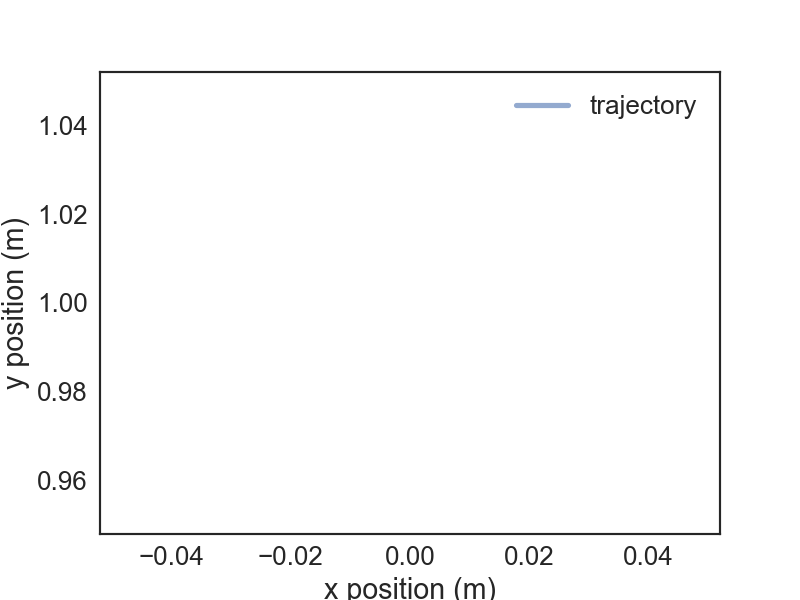

In [153]:
#trajectory plot
newfig()
plot(xs, ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

<IPython.core.display.Javascript object>


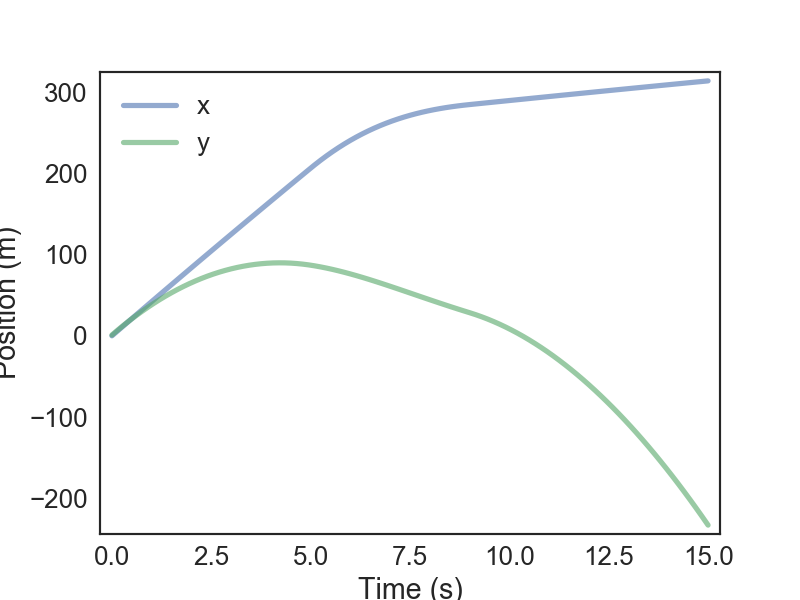

In [145]:
#plotting x and y as functions of time
newfig()
plot(xs, label='x')
plot(ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

In [146]:
xs = system.results.x
ys = system.results.y
xvs = system.results.vx
yvs = system.results.vy

yvs.loc[13]

KeyError: 'the label [13] is not in the [index]'

In [147]:
yvs.tail

<bound method NDFrame.tail of 0.00     42.426407
0.15     40.875485
0.30     39.329058
0.45     37.786974
0.60     36.249083
0.75     34.715238
0.90     33.185296
1.05     31.659117
1.20     30.136566
1.35     28.617511
1.50     27.101822
1.65     25.589376
1.80     24.080053
1.95     22.573736
2.10     21.070316
2.25     19.569686
2.40     18.071744
2.55     16.576396
2.70     15.083551
2.85     13.593125
3.00     12.105041
3.15     10.619225
3.30      9.135614
3.45      7.654150
3.60      6.174781
3.75      4.697465
3.90      3.222164
4.05      1.748850
4.20      0.277504
4.35     -1.191890
           ...    
10.65   -31.057561
10.80   -32.494147
10.95   -33.927685
11.10   -35.358047
11.25   -36.785106
11.40   -38.208738
11.55   -39.628817
11.70   -41.045223
11.85   -42.457833
12.00   -43.866528
12.15   -45.271188
12.30   -46.671698
12.45   -48.067941
12.60   -49.459804
12.75   -50.847173
12.90   -52.229939
13.05   -53.607991
13.20   -54.981222
13.35   -56.349526
13.50   -57.712799
1

In [148]:
xvs.tail

<bound method NDFrame.tail of 0.00     42.426407
0.15     42.344062
0.30     42.263444
0.45     42.184511
0.60     42.107220
0.75     42.031526
0.90     41.957386
1.05     41.884754
1.20     41.813581
1.35     41.743822
1.50     41.675424
1.65     41.608339
1.80     41.542514
1.95     41.477894
2.10     41.414425
2.25     41.352049
2.40     41.290708
2.55     41.230342
2.70     41.170889
2.85     41.112286
3.00     41.054468
3.15     40.997368
3.30     40.940920
3.45     40.885054
3.60     40.829700
3.75     40.774789
3.90     40.720249
4.05     40.666008
4.20     40.611996
4.35     40.558140
           ...    
10.65     4.929372
10.80     4.924192
10.95     4.918790
11.10     4.913166
11.25     4.907321
11.40     4.901257
11.55     4.894975
11.70     4.888477
11.85     4.881762
12.00     4.874834
12.15     4.867693
12.30     4.860342
12.45     4.852780
12.60     4.845011
12.75     4.837036
12.90     4.828856
13.05     4.820474
13.20     4.811891
13.35     4.803108
13.50     4.794129
1

In [149]:
x, y, vx, vy = 1, 2, 3, 4
unpack(system)
v = Vector(vx, vy)
v.mag

<Quantity(5.0, 'dimensionless')>

<IPython.core.display.Javascript object>


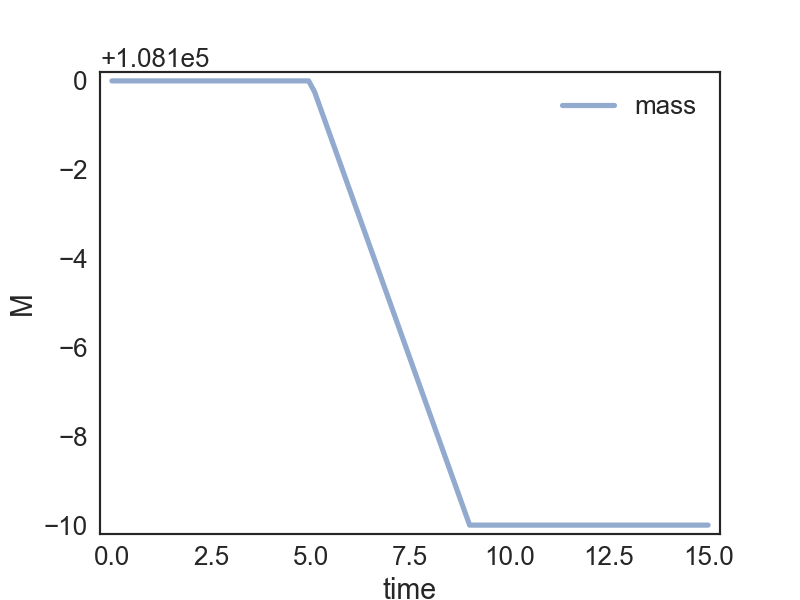

In [150]:
#trajectory plot
newfig()
plot(ms, label='mass')

decorate(xlabel='time',
         ylabel='M')

<IPython.core.display.Javascript object>


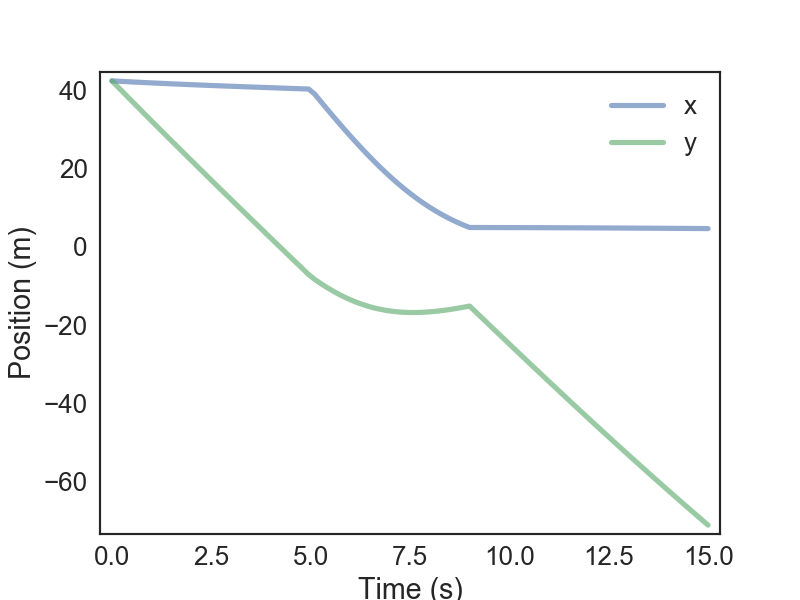

In [141]:
newfig()
plot(xvs, label='x')
plot(yvs, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')